# I. Import the data set and the required libraries

In [4]:
# Let's import the required libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Libraries for Modeling and Forecasting
# pip install skforecast==0.4.1
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

warnings.filterwarnings("ignore")
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
# Define figure style
sns.set()
plt.style.use("seaborn-whitegrid")
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_style("whitegrid")

<IPython.core.display.Javascript object>

In [6]:
# Import data set
boston_df = pd.read_csv(
    "Boston_Scientific.csv", sep=";", decimal=",", encoding="latin-1"
)

boston_df["Date"] = pd.to_datetime(boston_df["Date"], format="%Y.%m.%d")
boston_df = boston_df.set_index("Date")

my_data = boston_df.iloc[:, :]
print(my_data.shape)
my_data.head()

(1602, 3)


,Users,Lockdown_flag,Campaigns_flag
Date,,,
2017-01-11,1,0,0
2017-01-12,1,0,0
2017-01-13,1,0,0
2017-01-14,1,0,0
2017-01-15,3,0,0


<IPython.core.display.Javascript object>

In [7]:
# Let's check if there is any missing values in my data
print(f"Number of rows with missing values: {my_data.isnull().any(axis=1).mean()}")

# Verify that a temporary index is complete
print(
    (
        my_data.index
        == pd.date_range(
            start=my_data.index.min(),
            end=my_data.index.max(),
            freq=my_data.index.freq,
        )
    ).all()
)

Number of rows with missing values: 0.0
True


<IPython.core.display.Javascript object>

Train dates : From  2017-01-11 00:00:00  to  2020-07-15 00:00:00  (n=1282)
Test dates  : From  2020-07-16 00:00:00  to  2021-05-31 00:00:00  (n=320)


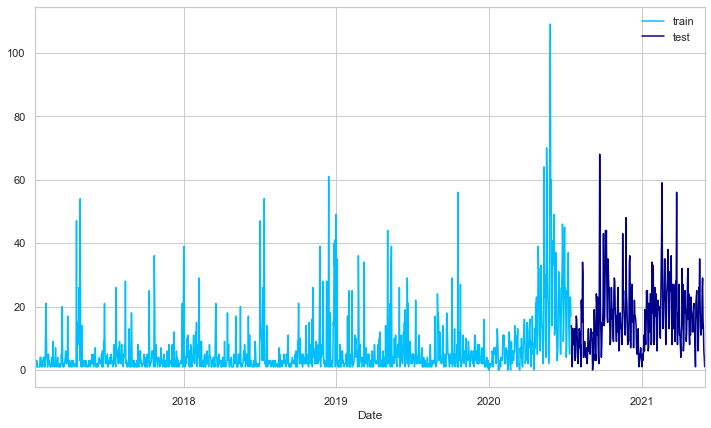

<IPython.core.display.Javascript object>

In [9]:
# The last 20% of the data will be used as the test set to evaluate the models

# Split data into train and test set

steps = int(round((len(my_data) * 0.2), 0))
data_train = my_data[:-steps]
data_test = my_data[-steps:]

print(
    f"Train dates : From  {data_train.index.min()}  to  {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : From  {data_test.index.min()}  to  {data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(12, 7))
data_train["Users"].plot(ax=ax, label="train", color="deepskyblue")
data_test["Users"].plot(ax=ax, label="test", color="darkblue")
ax.legend()

# II. Modelling

### II.1. ForecasterAutoreg

With the ForecasterAutoreg, a model is created and trained from a RandomForestRegressor regressor with a time window of N lags. If lags=60, this means that the model uses the previous 60 days as predictors.

In [7]:
# Model optimisation

# Hyperparameter Grid search
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=12,  # This value will be replaced in the grid search
)

# Lags used as predictors
lags_grid = [100, 200]

# Regressor's hyperparameters
param_grid = {"n_estimators": [1000, 5000]}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["Users"],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=True,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) * 0.7),  # I should try with 0.7
    # fixed_train_size=False,
    return_best=True,
    verbose=False,
)

Number of models compared: 4


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [26:44<00:00, 802.38s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
  params: {'n_estimators': 5000}



<IPython.core.display.Javascript object>

In [8]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(
    n_estimators=results_grid.iloc[0, :].params["n_estimators"],
    random_state=123,
)
forecaster = ForecasterAutoreg(
    regressor=regressor, lags=len(results_grid.iloc[0, :].lags)
)

forecaster.fit(y=data_train["Users"])

<IPython.core.display.Javascript object>

In [9]:
predictions = forecaster.predict(steps=steps)

# Test error
error_mse = mean_squared_error(y_true=data_test["Users"], y_pred=predictions)
print(f"Test error (rmse): {np.sqrt(error_mse)}")



Test error (rmse): 19.151288738375417


<IPython.core.display.Javascript object>

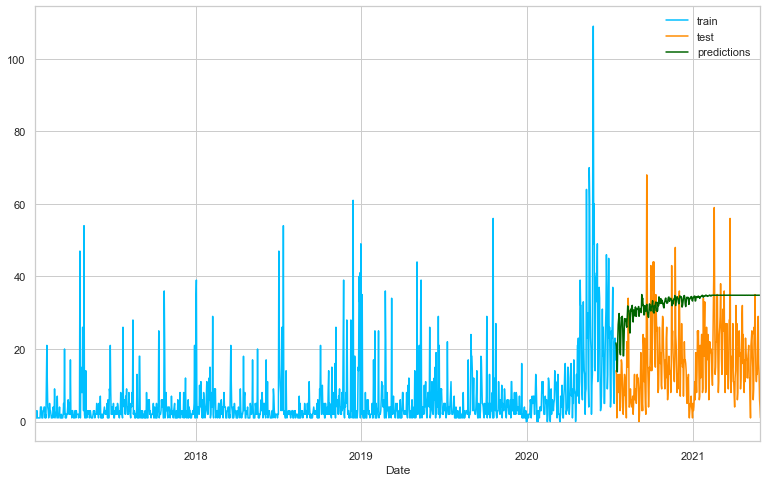

<IPython.core.display.Javascript object>

In [10]:
# Plot the predictions
data_test["predictions"] = predictions.tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
data_train["Users"].plot(ax=ax, label="train", color="deepskyblue")
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

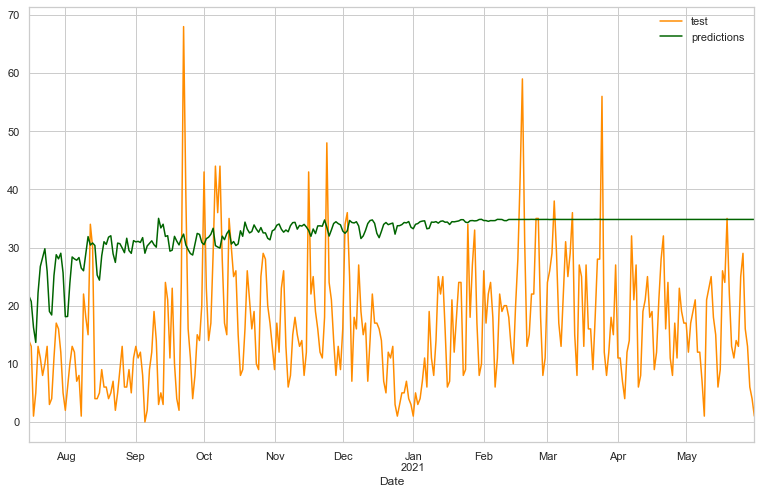

<IPython.core.display.Javascript object>

In [11]:
# Plot the predictions
data_test["predictions"] = predictions.tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

### II.2. Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

Here I followed a backtesting with refit strategy is followed. Internally, the process that the function applies is:

- In the first iteration, the model is trained with the observations selected for the initial training. Then, the next 80 observations are used to validate the predictions of this first model.

- In the second iteration, the model is retrained by adding, to the initial training set, the previous 80 validation observations. In the same way, the next 80 observations are established as the new validation set.

- This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.

For more information: https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html 

In [19]:
# Backtesting
# ==============================================================================
steps = 80
n_backtesting = 80 * 4

metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=my_data["Users"],
    initial_train_size=len(my_data) - n_backtesting,
    # fixed_train_size=False,
    steps=steps,
    metric="mean_squared_error",
    refit=True,
    verbose=True,
)

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1282
Number of observations used for backtesting: 320
    Number of folds: 4
    Number of steps per fold: 80

Data partition in fold: 0
    Training:   2017-01-11 00:00:00 -- 2020-07-15 00:00:00
    Validation: 2020-07-16 00:00:00 -- 2020-10-03 00:00:00
Data partition in fold: 1
    Training:   2017-01-11 00:00:00 -- 2020-10-03 00:00:00
    Validation: 2020-10-04 00:00:00 -- 2020-12-22 00:00:00
Data partition in fold: 2
    Training:   2017-01-11 00:00:00 -- 2020-12-22 00:00:00
    Validation: 2020-12-23 00:00:00 -- 2021-03-12 00:00:00
Data partition in fold: 3
    Training:   2017-01-11 00:00:00 -- 2021-03-12 00:00:00
    Validation: 2021-03-13 00:00:00 -- 2021-05-31 00:00:00

Backtest error: [196.06219]


<IPython.core.display.Javascript object>

In [20]:
# Test error
error_mse = mean_squared_error(y_true=data_test["Users"], y_pred=predictions_backtest)

print(f"Test error (rmse): {np.sqrt(error_mse)}")

Test error (rmse): 14.002220895272293


<IPython.core.display.Javascript object>

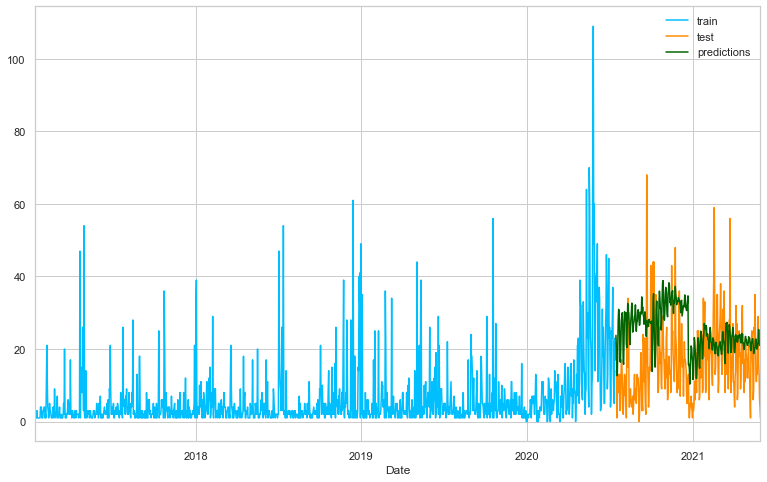

<IPython.core.display.Javascript object>

In [21]:
# Plot the predictions
data_test["predictions"] = predictions_backtest["pred"].tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
data_train["Users"].plot(ax=ax, label="train", color="deepskyblue")
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

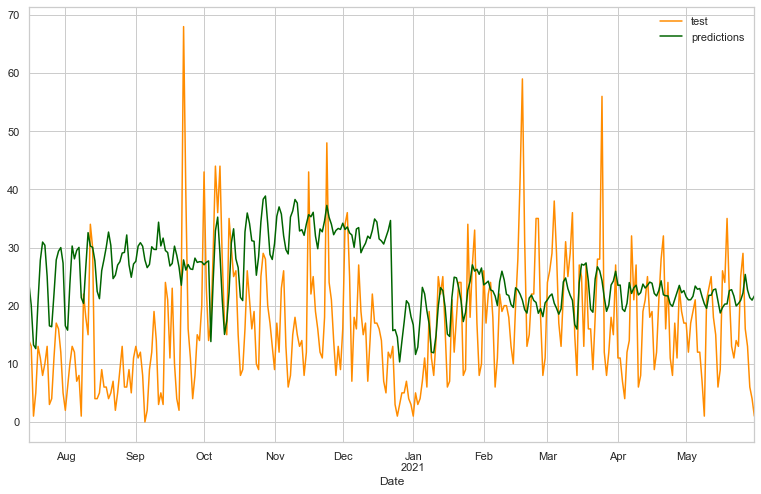

<IPython.core.display.Javascript object>

In [22]:
# Plot the predictions
data_test["predictions"] = predictions_backtest["pred"].tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

### II.3. Recursive autoregressive forecasting with exogenous variables

In our dataset we have exogenous factors like"Lockdown_flag" and "Campaigns_flag". So let's include them in the ForecasterAutoreg model

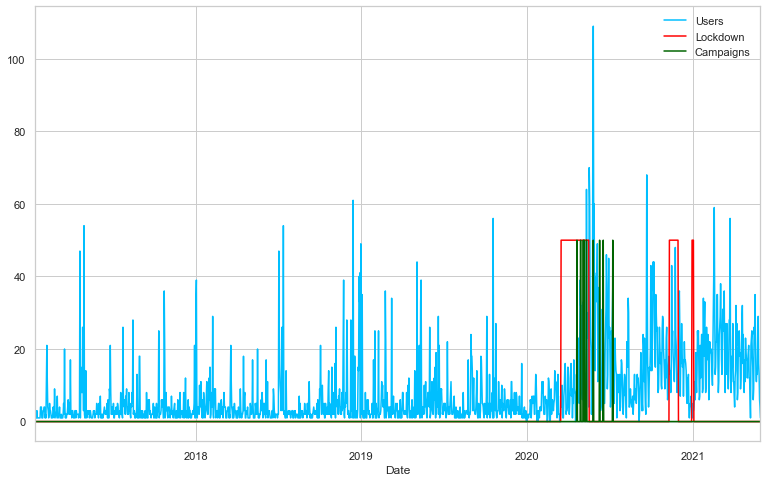

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(figsize=(13, 8))
my_data["Users"].plot(ax=ax, label="Users", color="deepskyblue")
(my_data["Lockdown_flag"] * 50).plot(ax=ax, label="Lockdown", color="red")
(my_data["Campaigns_flag"] * 50).plot(ax=ax, label="Campaigns", color="darkgreen")
ax.legend()

In [28]:
# Split data into train-test
steps = int(round((len(my_data) * 0.2), 0))
data_train = my_data[:-steps]
data_test = my_data[-steps:]

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2017-01-11 00:00:00 --- 2020-07-15 00:00:00  (n=1282)
Test dates  : 2020-07-16 00:00:00 --- 2021-05-31 00:00:00  (n=320)


<IPython.core.display.Javascript object>

In [33]:
# ForecasterAutoreg

# Hyperparameter Grid search

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=12,  # This value will be replaced in the grid search
)

lags_grid = [100, 200]

param_grid = {"n_estimators": [1000, 5000]}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["Users"],
    exog=data_train["Lockdown_flag"] + data_train["Campaigns_flag"],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=True,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) * 0.5),
    return_best=True,
    verbose=False,
)

Number of models compared: 4


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [29:03<00:00, 871.84s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
  params: {'n_estimators': 5000}



<IPython.core.display.Javascript object>

In [34]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123, n_estimators=5000),
    lags=200,
)

forecaster.fit(
    y=data_train["Users"],
    exog=data_train["Lockdown_flag"] + data_train["Campaigns_flag"],
)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=5000, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
Window size: 200 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.cor

<IPython.core.display.Javascript object>

In [35]:
# Predictions
predictions_exog = forecaster.predict(
    steps=steps, exog=data_test["Lockdown_flag"] + data_test["Lockdown_flag"]
)

<IPython.core.display.Javascript object>

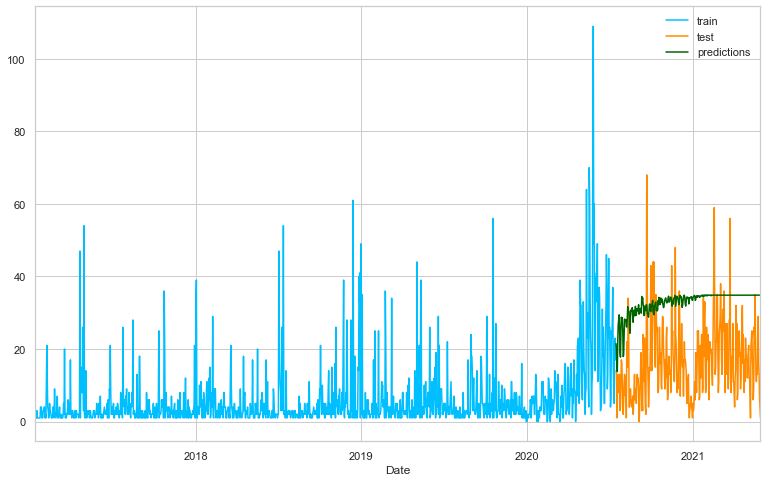

<IPython.core.display.Javascript object>

In [36]:
# Plot the predictions
data_test["predictions"] = predictions_exog.tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
data_train["Users"].plot(ax=ax, label="train", color="deepskyblue")
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

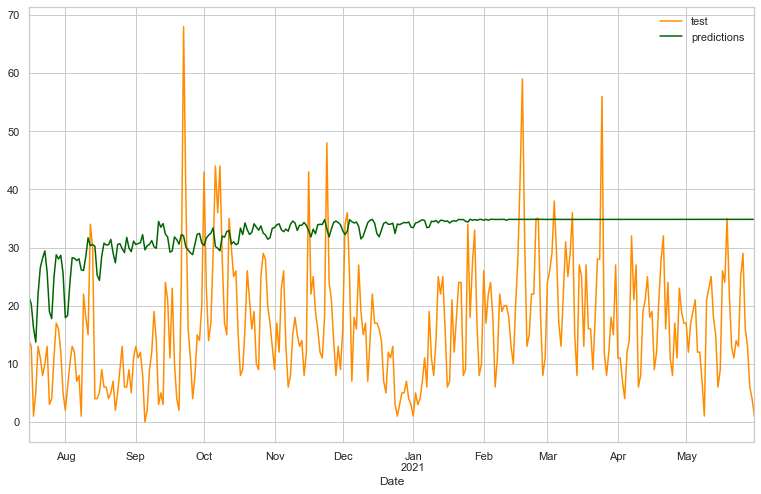

<IPython.core.display.Javascript object>

In [37]:
# Plot the predictions
data_test["predictions"] = predictions_exog.tolist()

# Fig
fig, ax = plt.subplots(figsize=(13, 8))
# data_train["Users"].plot(ax=ax, label="train", color="deepskyblue")
data_test["Users"].plot(ax=ax, label="test", color="darkorange")
data_test["predictions"].plot(ax=ax, label="predictions", color="darkgreen")
ax.legend()

# Drop predictions from data_test
data_test.drop(["predictions"], axis=1, inplace=True)

# III. Prediction for the year 2023

In [16]:
# Create a data set until 2023
data_2023 = pd.DataFrame()
data_2023["Date"], data_2023["Lockdown_flag"], data_2023["Campaigns_flag"] = (
    pd.date_range("06-01-2021", "31-12-2023"),
    0,
    0,
)

data_2023["Date"] = pd.to_datetime(data_2023["Date"], format="%Y.%m.%d")
data_2023 = data_2023.set_index("Date")

<IPython.core.display.Javascript object>

In [39]:
# Train on all the data set
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123, n_estimators=5000),
    lags=200,
)

forecaster.fit(
    y=my_data["Users"],
    exog=my_data["Lockdown_flag"] + my_data["Campaigns_flag"],
)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=5000, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
Window size: 200 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.cor

<IPython.core.display.Javascript object>

In [40]:
# Predictions for 2023
predictions_exog = forecaster.predict(
    steps=(len(data_2023)), exog=data_2023["Lockdown_flag"] + data_2023["Lockdown_flag"]
)

<IPython.core.display.Javascript object>

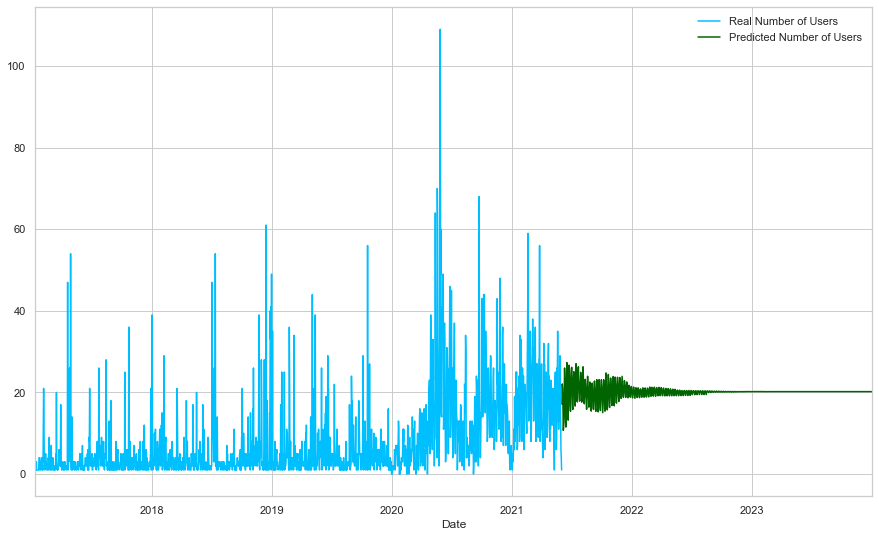

<IPython.core.display.Javascript object>

In [41]:
# Plot the predictions
data_2023["Users"] = predictions_exog.tolist()

# Fig
fig, ax = plt.subplots(figsize=(15, 9))
my_data["Users"].plot(ax=ax, label="Real Number of Users", color="deepskyblue")
data_2023["Users"].plot(ax=ax, label="Predicted Number of Users", color="darkgreen")
ax.legend()